In [1]:
import os
import matplotlib.pyplot as plt
import math
import cv2
import numpy as np

In [2]:
sources_coordinates_file = open('coordinates.txt', 'r')
sources_coordinates_lines = sources_coordinates_file.readlines()

In [3]:
converted_lines = []
for line in sources_coordinates_lines:
    integers = [str(int(float(num))) for num in line.split(",")]
    converted_lines.append(", ".join(integers))

In [4]:
NUM_IMAGES_TRAINING_SET = 3400

In [5]:
import re
data_path = '/Users/antonyzappacosta/Desktop/gamma_sources_identification/CNN_project/dataset'
# ASSUMING WE ARE DOING BINARY CLASSIFICATION
def load_data():
    # let's put directly images inside these arrays and not only image paths
    x_train = []
    y_train_loc = []
    x_test = []
    y_test_loc = []

    train_bkg_count = 0
    train_src_count = 0

    for img_name in os.listdir(data_path):
        img_full_path = data_path + '/' + img_name
        #print(img_full_path)
        image = cv2.imread(img_full_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.pyrDown(image)
        image = cv2.pyrDown(image)
        image = cv2.pyrDown(image)
        img_index = int(re.findall('\d+', img_name )[0])
        source_x = int(converted_lines[img_index].split(",")[1])
        source_y = int(converted_lines[img_index].split(",")[2])
        source_coordinates = (source_x, source_y)
        
        if train_src_count < NUM_IMAGES_TRAINING_SET:
            x_train.append(image)
            y_train_loc.append(source_coordinates)
            train_src_count += 1
        else: # append in test set
            x_test.append(image)
            y_test_loc.append(source_coordinates)
            train_src_count += 1

    x_train = np.array(x_train)
    y_train_loc = np.array(y_train_loc)
    x_test = np.array(x_test)
    y_test_loc = np.array(y_test_loc)
    
    #return (x_train, y_train), (x_test, y_test)
    return (x_train, y_train_loc), (x_test, y_test_loc)

In [6]:
#(x_train, y_train), (x_test, y_test) = load_data()
(x_train, y_train_loc), (x_test, y_test_loc) = load_data()

In [7]:
y_train_loc = y_train_loc / 8
y_test_loc = y_test_loc / 8
print(x_train.shape)
print(y_train_loc.shape)
print(x_test.shape)
print(y_test_loc.shape)

(3400, 63, 63)
(3400, 2)
(600, 63, 63)
(600, 2)


In [8]:
print(y_train_loc)

[[34.75  28.75 ]
 [19.    26.75 ]
 [48.625 30.375]
 ...
 [43.5   15.125]
 [44.    17.75 ]
 [21.875 47.125]]


In [8]:
x_train = x_train / 255
x_test = x_test / 255

In [129]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2

# Define the input shape based on your image size
input_shape = (63, 63, 1)

# Define the model architecture with regularization
def create_model():
    input_layer = Input(shape=input_shape)
    
    # Convolutional layers with L2 regularization
    conv1 = Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01))(input_layer)
    maxpool1 = MaxPooling2D((2, 2))(conv1)
    
    conv2 = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01))(maxpool1)
    maxpool2 = MaxPooling2D((2, 2))(conv2)
    
    # Flatten layer
    flatten = Flatten()(maxpool2)
    
    # Dense layers with dropout
    dense1 = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(flatten)
    dropout1 = Dropout(0.5)(dense1)  # Dropout layer with 50% dropout rate

    # Add an additional dense layer with dropout
    dense2 = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(dropout1)
    dropout2 = Dropout(0.5)(dense2)  # Dropout layer with 50% dropout rate
    
    output_layer = Dense(2)(dropout2)  # Output layer with 2 neurons for x and y coordinates
    
    model = Model(inputs=input_layer, outputs=output_layer)
    return model


In [9]:
################## LOADING THE MODEL ####################
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model

model=load_model('gamma_conv_model_0209-00e31.h5')

2023-09-02 16:01:17.745381: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [130]:
from tensorflow.keras.callbacks import EarlyStopping
model = create_model()

# Create EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=7,          # Number of epochs with no improvement to wait before stopping
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [ ]:

# Train the model using data augmentation
batch_size = 32
epochs = 5000

history = model.fit(
    x_train, y_train_loc,
    validation_split=0.1,
    batch_size=batch_size,
    epochs=epochs,
)

1/1 [==============================] - 0s 23ms/step


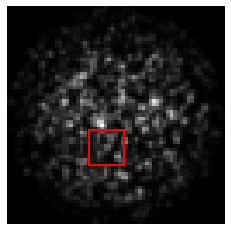

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Assuming you have the model predictions for a test image
test_image_index = 223# Change this to the index of the test image you want to visualize
test_image = x_test[test_image_index]
coord_predictions = model.predict(np.expand_dims(test_image, axis=0))


# Extract predicted coordinates
predicted_coords = coord_predictions[0]
predicted_coords[0] = predicted_coords[0]
predicted_coords[1] = predicted_coords[1]
#print(coord_predictions)

# Display the test image
plt.imshow(test_image, cmap='gray')
plt.axis('off')

# Add bounding box if source is predicted

x, y = predicted_coords  # Adjust coordinates according to your format
width = height = 10  # Adjust these values according to your desired box size
rect = patches.Rectangle((x - width/2, y - height/2), width, height, linewidth=2, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect)

plt.show()


In [12]:
model.save('gamma_conv_model_0209-00e31.h5')
print('Model Saved!')

Model Saved!


/opt/miniconda3/envs/cta_simulation/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
model.save('gamma_conv_model_0209-00e31.keras')
print('Model Saved!')

Model Saved!
